<a href="https://colab.research.google.com/github/srohit0/food_mnist/blob/master/Keras_food_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# food MNIST


<img src=https://raw.githubusercontent.com/srohit0/food_mnist/master/images/food-collage.jpg  width="800" height="400" align="center">

In [0]:
%%time

#! rm -fr food_mnist
#! git clone https://github.com/srohit0/food_mnist.git

import food_mnist
from google.colab.patches import cv2_imshow

CPU times: user 20.5 ms, sys: 6.09 ms, total: 26.5 ms
Wall time: 33.3 ms


## 1. Import Packages

In [0]:
import os
import numpy as np
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K


## 2. Load MNIST Dataset

In [0]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels



def divide_dataset(dataset, labels):
    train_pct = 0.80; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index, :]
    t_Y = labels[:train_index]
    v_X = dataset[train_index:,:]
    v_Y = labels[train_index:]
    
    return (t_X, t_Y), (v_X, v_Y)


In [0]:
batch_size = 512
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols, img_channels = 112, 112, 3
input_shape = (img_rows, img_cols, img_channels)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = food_mnist.load_data(img_cols, img_rows)
X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

X, Y = randomize(X, Y)
(x_train, y_train), (x_test, y_test) = divide_dataset(X, Y)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)


x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
def train_input_fn(batch_size=1000):
  # convert the inputs to a Dataset.
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))

  # shuffle, repeat, and batch the examples.
  dataset = dataset.shuffle(1000).repeat().batch(batch_size, drop_remainder=True)

  # return the dataset.
  return dataset

## 3. Define Deep Learning  Model

In [0]:
learning_rate = 0.001
filter_sz = 7
n_filters = 32
batch_size = 1000

def create_model():
  Inp = tf.keras.Input(name='input', shape=input_shape, batch_size=None, dtype=tf.float32)

  x = Conv2D(n_filters, kernel_size=(filter_sz, filter_sz), activation='relu',name = 'Conv_01')(Inp)
  x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
  x = Conv2D(2*n_filters, (filter_sz, filter_sz), activation='relu',name = 'Conv_02')(x)
  x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_02')(x)
  x = Conv2D(2*n_filters, (filter_sz, filter_sz), activation='relu',name = 'Conv_03')(x)
  x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_03')(x)
  x = Conv2D(2*n_filters, (filter_sz, filter_sz), activation='relu',name = 'Conv_04')(x)
  x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_04')(x)
  x = Flatten(name = 'Flatten_01')(x)
  x = Dense(2*n_filters, activation='relu',name = 'Dense_01')(x)
  x = Dropout(0.5,name = 'Dropout_02')(x)
  output = Dense(num_classes, activation='softmax',name = 'Dense_02')(x)
  
  return tf.keras.models.Model(inputs=[Inp], outputs=[output])

In [0]:
tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_grpc_url)
tf.config.experimental_connect_to_host(cluster_resolver.master())
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

## 4. Train The Model

In [0]:
with tpu_strategy.scope():
  model = create_model()
  opt = tf.train.AdamOptimizer(learning_rate)
  #opt = tf.train.AdadeltaOptimizer()
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
  model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
  print('\n########################################\n#   T E S T    A C C U R A C Y:', score[1]*100, "%\n########################################")

W0617 05:03:00.923497 140554039068544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0617 05:03:25.807128 140554039068544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_distributed.py:411: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Epoch 1/100
4/4 [==============================] - 11s 3s/step - loss: 2.3163 - acc: 0.1048 - val_loss: 2.2998 - val_acc: 0.0920
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 2.3014 - acc: 0.1070 - val_loss: 2.2974 - val_acc: 0.0950
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 2.2953 - acc: 0.1303 - val_loss: 2.2931 - val_acc: 0.1130
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 2.2885 - acc: 0.1183 - val_loss: 2.2728 - val_acc: 0.1880
Epoch 5/100
4/4 [==============================] - 8s 2s/step - loss: 2.2780 - acc: 0.1243 - val_loss: 2.2840 - val_acc: 0.1160
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 2.2773 - acc: 0.1258 - val_loss: 2.2246 - val_acc: 0.1930
Epoch 7/100
4/4 [==============================] - 10s 3s/step - loss: 2.2278 - acc: 0.1655 - val_loss: 2.2017 - val_acc: 0.1910
Epoch 8/100
4/4 [==============================] - 10s 3s/step - loss: 2.2077 - acc: 0.1795 - val_loss

## 5. Display !

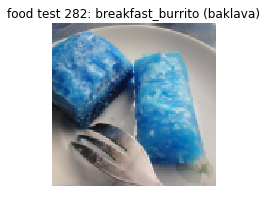

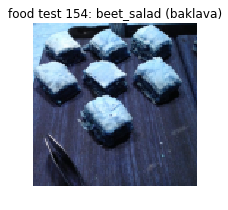

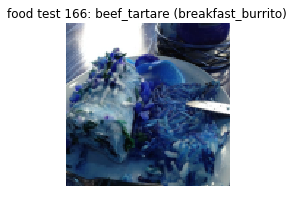

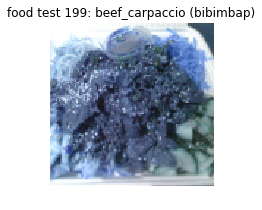

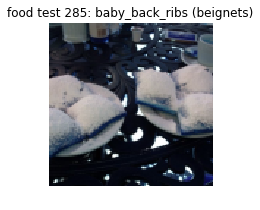

In [0]:
from matplotlib import pyplot as plt
import random

labels_dict = food_mnist.labels()
img_class = model.predict(x_test, batch_size=batch_size)

for x in range(5):
  idx = random.randint(0,x_test.shape[0])
  img = x_test[idx]
  fig=plt.figure(figsize=(3,3), dpi=72, facecolor='w', edgecolor='k')
  plt.axis('off')
  plt.imshow(img)
  plt.title("food test " + str(idx) + ": " + labels_dict[np.argmax(img_class[idx])] + 
            " (" + labels_dict[np.argmax(y_test[idx])] + ")" )
  
  plt.show()